# Basic CNN Framework for Landsat Classification

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

### importing datasets

In [139]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

"""
l8_image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']
"""

l8_image_paths = ['/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

s1_image_paths = ['/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif']

landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))



In [140]:
# What is the raster's projection?
image_proj = landsat_datasets[0].crs # 4326
print('Image projection:')
print(image_proj)
print('---')
# What is the raster's projection?
label_proj = sentinel_datasets[0].crs
print('Labels projection:')
print(label_proj)
print('---')
# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
---
Labels projection:
EPSG:4326
---
Labels projection:
EPSG:32618


### Class Dictionary and Confusion Matrix Function

In [4]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

"""
TO Run: 

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

plt.show()
"""


'\nTO Run: \n\nnp.set_printoptions(precision=2)\n\n# Plot non-normalized confusion matrix\nplot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),\n                      class_dict=class_names)\n\n# Plot normalized confusion matrix\nplot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),\n                      class_dict=class_names,\n                      normalize=True)\n\nplt.show()\n'

## Data Generator and Prep Fcns

This is a typical Keras generator that I've written to allow it to ingest a set of random pixel locations so we can randomly sample throughout the images.

In [141]:
def tile_generator(l8_image_datasets, s1_image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1
    # merge some of the labels
    # medium intensity and high intensity
    label_image[label_image == 3] = 2
    # open space developed and cultivated land
    label_image[label_image == 5] = 6
    # pasture/hay and grassland
    label_image[label_image == 7] = 8
    # deciduous forest and mixed forest
    label_image[label_image == 9] = 11
    # estuarine forest wetland to palustrine forested wetland
    label_image[label_image == 16] = 13

    c = r = 0
    i = 0
    
    label_proj = Proj(label_dataset.crs)
    l8_proj = Proj(l8_image_datasets[0].crs)
    s1_proj = Proj(s1_image_datasets[0].crs)

    # assuming all images have the same num of bands
    l8_band_count = l8_image_datasets[0].count  
    s1_band_count = s1_image_datasets[0].count
    band_count = l8_band_count + s1_band_count
    class_count = len(class_names)
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, band_count-1)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = l8_image_datasets[dataset_index].read(list(np.arange(1, l8_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (l8_band_count, tile_width, tile_height):
                print('wrong shape')
                print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                # set medium developed to high dev
                #tile[tile == 3] = 2
                
                # taking off the QA band and adjusting the rest
                tile = adjust_band(tile[0:7])
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                
                ### get sentinel 1 tile

                # find gps of that pixel within the image
                (x, y) = l8_image_datasets[dataset_index].xy(r, c)
                
                # convert the point we're sampling from to the same projection as the label dataset if necessary
                if l8_proj != s1_proj:
                    x,y = transform(l8_proj,s1_proj,x,y)

                # reference gps in sentinel 1 to get matching pixel
                row, col = s1_image_datasets[dataset_index].index(x,y)

                # read in the s1 data 
                s1_tile = s1_image_datasets[dataset_index].read(list(np.arange(1, s1_band_count+1)), window=Window(col-buffer, row-buffer, tile_width, tile_height))
                
                if np.isnan(s1_tile).any() == True:
                    pass
                else:
                    reshaped_s1_tile = reshape_as_image(s1_tile)
                    ### get label data
                    
                    # find gps of that pixel within the image
                    (x, y) = l8_image_datasets[dataset_index].xy(r, c)

                    # convert the point we're sampling from to the same projection as the label dataset if necessary
                    if l8_proj != label_proj:
                        x,y = transform(l8_proj,label_proj,x,y)

                    # reference gps in label_image
                    row, col = label_dataset.index(x,y)

                    # find label
                    label = label_image[:, row, col]
                    # if this label is part of the unclassified area then ignore
                    if label == 0 or np.isnan(label).any() == True:
                        pass
                    else:                   
                        # add label to the batch in a one hot encoding style
                        label_batch[b][label] = 1
                        image_batch[b] = np.dstack( ( reshaped_tile, reshaped_s1_tile ) )
                        
                        b += 1
        yield (image_batch, label_batch)


This function takes in a list of raster datasets and randomly samples `train_count` and `val_count` random pixels from each dataset.

It doesn't sample within tile_size / 2 of the edge in order to avoid missing data.

In [101]:
def gen_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    val_count_per_dataset = math.ceil(val_count / len(image_datasets))
   
    total_count_per_dataset = train_count_per_dataset + val_count_per_dataset
    for index, image_dataset in enumerate(image_datasets):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = random.sample(set(itertools.product(rows, columns)), total_count_per_dataset)
        
        dataset_index_list = [index] * total_count_per_dataset
        
        dataset_pixels = list(zip(points, dataset_index_list))
        
        train_pixels += dataset_pixels[:train_count_per_dataset]
        val_pixels += dataset_pixels[train_count_per_dataset:]
        
        
    return (train_pixels, val_pixels)

## Test out the generator and data prep functions

Let's make sure all this data prep actually works.

In [122]:
# generate the training and validation pixel locations
train_px, val_px = gen_pixel_locations(landsat_datasets, 20, 20, 64)

In [142]:
# print out some image and label batches and check out their shapes
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets, sentinel_datasets, label_dataset, 64, 64, train_px, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label)
    print(label.shape)
    print('----')
    count += 1
    im_batch = im

Image
(10, 64, 64, 9)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
(10, 26)
----
Image
(10, 64, 64, 9)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0.

### Visually inspect an image patch

While it shouldn't necessarily be recognizable it should look like it has data in it and that it varies somewhat from pixel to pixel.

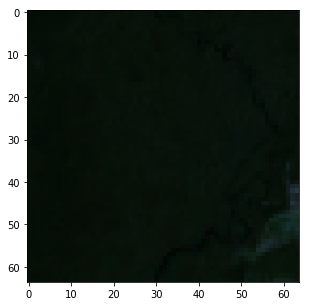

In [157]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 

axs.imshow(im_batch[0,:,:,1:4])

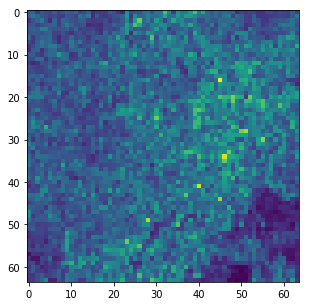

In [156]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 
axs.imshow(im_batch[0,:,:,8])

## Let's get to the CNN Development!!

In [183]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [184]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### prep some of the hyperparameters

In [191]:
batch_size = 25
label_image[label_image == 255] = 1
num_classes = len(class_names)
epochs = 50

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(64, 64, 9)


### build the model

This is just a simple CNN model but it should be able to perform well above random when predicting landcover types if everything is correct thus far.

In [192]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(22, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 62, 62, 64)        5248      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 60, 22)        12694     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 22)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 30, 22)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 30, 64)        12736     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 64)        0         
__________

In [82]:
from keras.models import Model
mod = Model([inputs=[inputs], outputs=[conv2]])
mod.predict(inp_data)

SyntaxError: invalid syntax (<ipython-input-82-da7b2d6e9450>, line 2)

In [94]:
from keras import regularizers

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

NameError: name 'regularizers' is not defined

#### Generate the train/validation pixel locations to train with

In [187]:
train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=20000, val_count=5000, tile_size=tile_side)

#### set up the remaining model hyperparameters and compile

In [193]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

#### TRAIN THE MODEL!

In [ ]:
model.fit_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator(landsat_datasets, sentinel_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/50
800/800 [==============================] - 46s 57ms/step - loss: 2.0071 - acc: 0.2871 - val_loss: 1.8513 - val_acc: 0.3786
Epoch 2/50
800/800 [==============================] - 43s 54ms/step - loss: 1.8030 - acc: 0.3834 - val_loss: 1.7407 - val_acc: 0.4186
Epoch 3/50
533/800 [==================>...........] - ETA: 11s - loss: 1.7219 - acc: 0.4079

### Now let's evaluate the Model

We'll just generate 500 test pixels to evaluate it on

Keras has a built in evaluate_generator function and because we told it above to use accuracy as a metric this function automatically outputs categorical accuracy which is what we want.

In [86]:
train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=0, val_count=10000, tile_size=tile_side)

In [87]:
model.evaluate_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

400/400 [==============================] - 20s 51ms/step


[1.7156081221997739, 0.4223999988101423]

So in this simple model we're getting 37% accuracy across 23 classes which is well above the random accuracy which would be around 4% (aka 1/23). That means we're in business!

### Evaluating the model ourselves

If we wanted to run this evaluation and take a look at specific predictions and labels we can do that below (albeit more inefficiently) just to get an intuitive understanding of what is going wrong.

In [88]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, label_dataset, 
                        tile_side, tile_side, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)


400/400 [==============================] - 20s 50ms/step


In [89]:
eval_generator = tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_px, batch_size=1)

In [90]:
labels = np.empty(predictions.shape)
count = 0
while count < len(val_px):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

In [91]:
labels.shape

(10000, 26)

In [92]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

In [93]:
correct_predictions = np.zeros(pred_index.shape)
correct_predictions[label_index == pred_index] = 1

In [94]:
np.count_nonzero(correct_predictions) / len(val_px)

0.4224

Now maybe more informatively let's build a confusion matrix using the scikit-learn function.

Read the docs here and make this more informative by following some of their examples: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

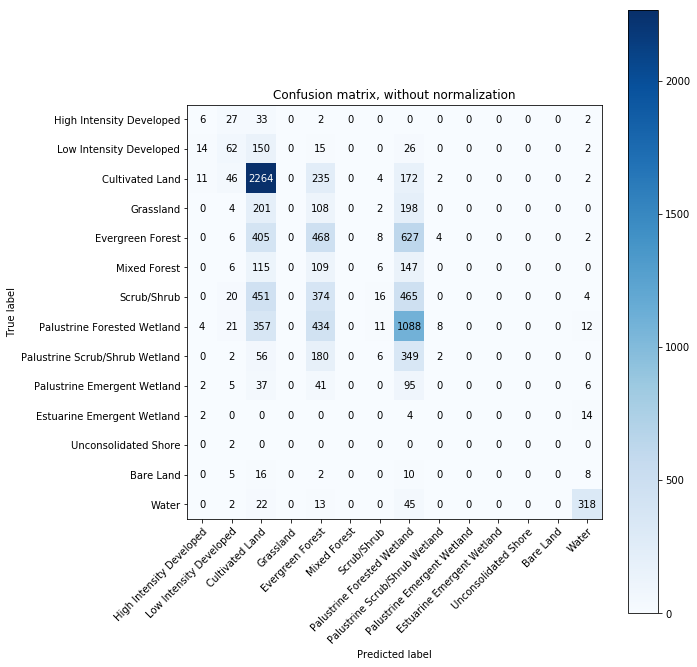

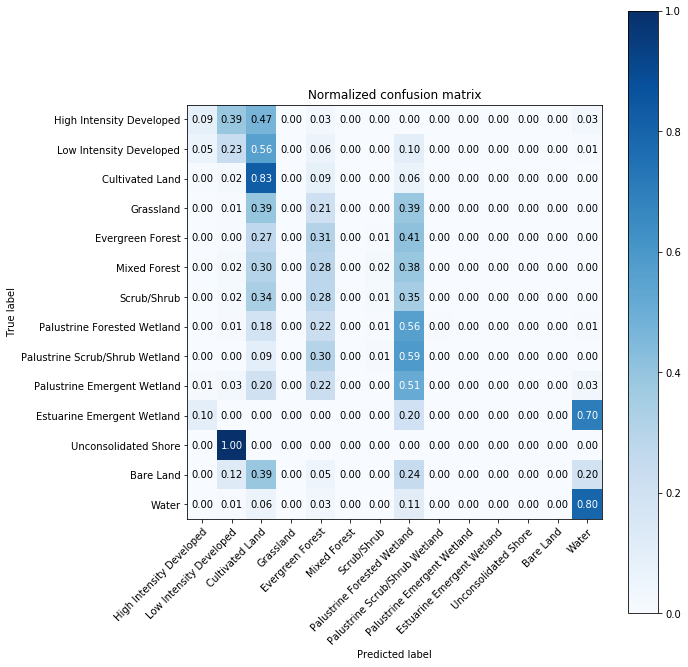

In [95]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [96]:
unique, counts = np.unique(label_index, return_counts=True)
dict(zip(unique, counts))

{2: 70,
 4: 269,
 6: 2736,
 8: 513,
 10: 1520,
 11: 383,
 12: 1330,
 13: 1935,
 14: 595,
 15: 186,
 18: 20,
 19: 2,
 20: 41,
 21: 400}

## Scikit-learn ML Approaches

In [176]:
def pixel_generator(l8_image_datasets, s1_image_datasets, label_dataset, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1
    # merge some of the labels
    # medium intensity and high intensity
    label_image[label_image == 3] = 2
    # open space developed and cultivated land
    label_image[label_image == 5] = 6
    # pasture/hay and grassland
    label_image[label_image == 7] = 8
    # deciduous forest and mixed forest
    label_image[label_image == 9] = 11
    # estuarine forest wetland to palustrine forested wetland
    label_image[label_image == 16] = 13

    c = r = 0
    i = 0
    
    label_proj = Proj(label_dataset.crs)
    l8_proj = Proj(l8_image_datasets[0].crs)
    s1_proj = Proj(s1_image_datasets[0].crs)

    # assuming all images have the same num of bands
    l8_band_count = l8_image_datasets[0].count  
    s1_band_count = s1_image_datasets[0].count
    band_count = l8_band_count + s1_band_count
    class_count = len(class_names)
  
    while True:
        image_batch = np.zeros((batch_size, band_count-1)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = l8_image_datasets[dataset_index].read(list(np.arange(1, l8_band_count+1)), window=Window(c, r, 1, 1))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                # set medium developed to high dev
                #tile[tile == 3] = 2
                
                # taking off the QA band and adjusting the rest
                tile = adjust_band(tile[0:7])
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                
                ### get sentinel 1 tile

                # find gps of that pixel within the image
                (x, y) = l8_image_datasets[dataset_index].xy(r, c)
                
                # convert the point we're sampling from to the same projection as the label dataset if necessary
                if l8_proj != s1_proj:
                    x,y = transform(l8_proj,s1_proj,x,y)

                # reference gps in sentinel 1 to get matching pixel
                row, col = s1_image_datasets[dataset_index].index(x,y)

                # read in the s1 data 
                s1_tile = s1_image_datasets[dataset_index].read(list(np.arange(1, s1_band_count+1)), window=Window(col, row, 1, 1))
                
                if np.isnan(s1_tile).any() == True:
                    pass
                else:
                    reshaped_s1_tile = reshape_as_image(s1_tile)
                    ### get label data
                    
                    # find gps of that pixel within the image
                    (x, y) = l8_image_datasets[dataset_index].xy(r, c)

                    # convert the point we're sampling from to the same projection as the label dataset if necessary
                    if l8_proj != label_proj:
                        x,y = transform(l8_proj,label_proj,x,y)

                    # reference gps in label_image
                    row, col = label_dataset.index(x,y)

                    # find label
                    label = label_image[:, row, col]
                    # if this label is part of the unclassified area then ignore
                    if label == 0 or np.isnan(label).any() == True:
                        pass
                    else:                   
                        # add label to the batch in a one hot encoding style
                        label_batch[b][label] = 1
                        image_batch[b] = np.dstack( ( reshaped_tile, reshaped_s1_tile ) )
                        
                        b += 1
        return (image_batch, label_batch)

In [12]:
def pixel_generator(image_datasets, label_dataset, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
  
    image_batch = np.zeros((batch_size, band_count))
    label_batch = np.zeros((batch_size, class_count))
    b = 0
    while b < batch_size:
        # if we're at the end  of the data just restart
        if i >= len(pixel_locations):
            i=0
        c, r = pixel_locations[i][0]
        dataset_index = pixel_locations[i][1]
        i += 1
        tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c, r, 1, 1))
        if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
            pass
        elif np.isnan(tile).any() == True or -9999 in tile: 
            # we don't want tiles containing nan or -9999 this comes from edges
            # this also takes a while and is inefficient
            pass
        else:
            tile = adjust_band(tile)
            # reshape from raster format to image format
            reshaped_tile = reshape_as_image(tile)

            # find gps of that pixel within the image
            (x, y) = image_datasets[dataset_index].xy(r, c)

            # convert the point we're sampling from to the same projection as the label dataset if necessary
            inProj = Proj(image_datasets[dataset_index].crs)
            if inProj != outProj:
                x,y = transform(inProj,outProj,x,y)

            # reference gps in label_image
            row, col = label_dataset.index(x,y)

            # find label
            label = label_image[:, row, col]
            # if this label is part of the unclassified area then ignore
            if label == 0 or np.isnan(label).any() == True:
                pass
            else:
                # add label to the batch in a one hot encoding style
                label_batch[b][label] = 1
                image_batch[b] = reshaped_tile
                b += 1
    return (image_batch, label_batch)
              

In [23]:
def sk_tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height * tile_width * band_count))
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                print('wrong shape')
                # somehow we're randomly getting tiles without the correct dimensions
                # I assume it is when the tiles are on the edge
                pass
            else:
                tile = adjust_band(tile)
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile.flatten()
                    b += 1
        return (image_batch, label_batch)


### Prep Data for training and validation

In [178]:
train_px, val_px = gen_pixel_locations(landsat_datasets, 50000, 0, 1)

In [179]:
batch_size = 50
sk_im_batch, sk_label_batch = pixel_generator(landsat_datasets, sentinel_datasets, label_dataset, train_px, batch_size)
print(sk_im_batch.shape, sk_label_batch.shape)

(50, 9) (50, 26)


In [85]:
batch_size = 1000
sk_im_batch_val, sk_label_batch_val = pixel_generator([landsat_dataset], label_dataset, val_px, batch_size)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(1000, 7) (1000, 23)


### K Nearest Neighbors

In [86]:
from sklearn import neighbors, datasets

n_neighbors = 50

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=50, p=2,
           weights='distance')

In [87]:
label_index = np.argmax(sk_label_batch_val, axis=1)

clf.score(sk_im_batch_val, label_index)

0.434

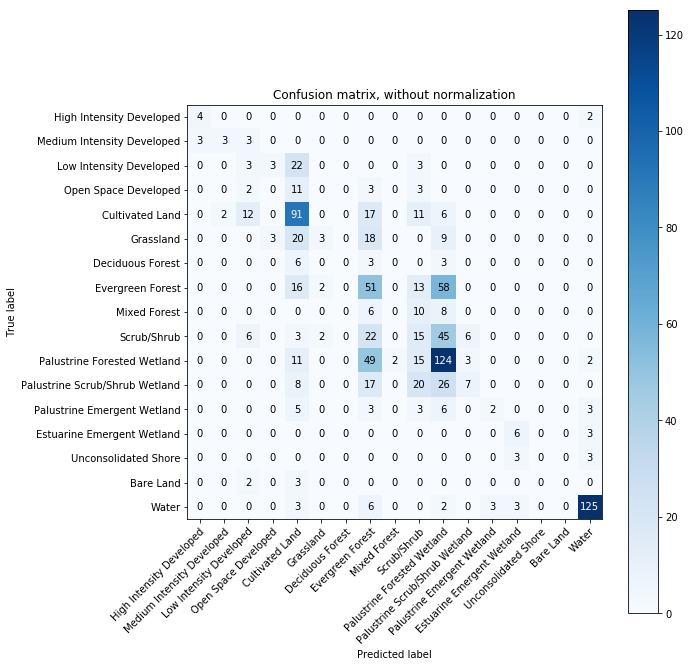

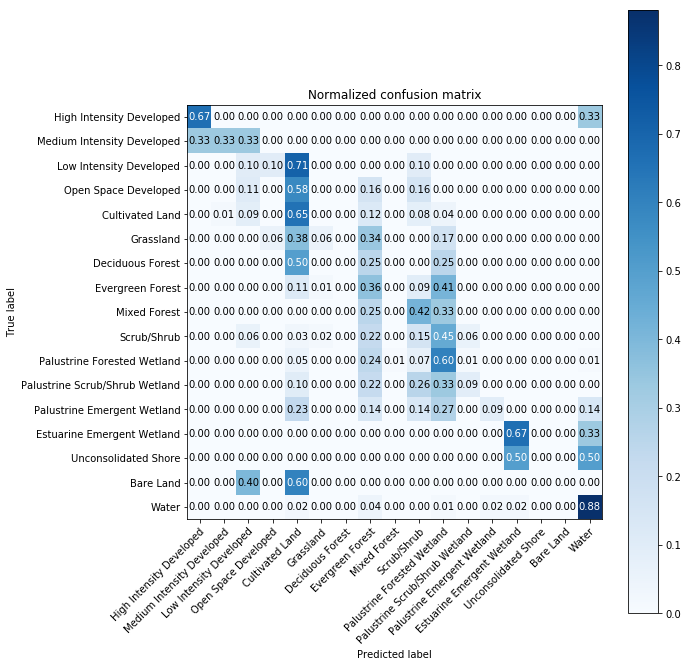

In [89]:
pred_index = clf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

(array([  6.,   9.,  31.,  19., 139.,   0.,  53.,  12., 140.,  24.,  99.,
        206.,  78.,  22.,   0.,   0.,   9.,   6.,   5., 142.]),
 array([ 2.  ,  2.95,  3.9 ,  4.85,  5.8 ,  6.75,  7.7 ,  8.65,  9.6 ,
        10.55, 11.5 , 12.45, 13.4 , 14.35, 15.3 , 16.25, 17.2 , 18.15,
        19.1 , 20.05, 21.  ]),
 <a list of 20 Patch objects>)

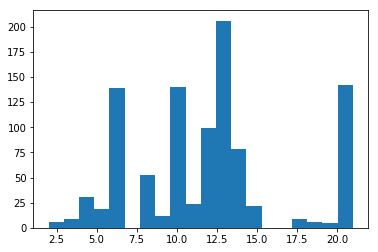

In [90]:
plt.hist(np.argmax(sk_label_batch_val, axis=1), bins=20)

(array([  7.,   5.,  28.,   6., 199.,   0.,   7.,   0., 195.,   2.,  93.,
        287.,  16.,   5.,   0.,   0.,  12.,   0.,   0., 138.]),
 array([ 2.  ,  2.95,  3.9 ,  4.85,  5.8 ,  6.75,  7.7 ,  8.65,  9.6 ,
        10.55, 11.5 , 12.45, 13.4 , 14.35, 15.3 , 16.25, 17.2 , 18.15,
        19.1 , 20.05, 21.  ]),
 <a list of 20 Patch objects>)

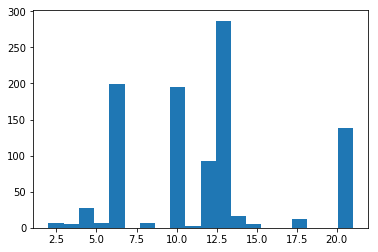

In [91]:
plt.hist(pred_index, bins=20)

### Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [93]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 100.0%


In [94]:
rf.score(sk_im_batch_val, label_index)

0.426

In [95]:
bands = [1, 2, 3, 4, 5, 6, 7]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.060171041657004015
Band 2 importance: 0.18287004257923808
Band 3 importance: 0.19148731593657997
Band 4 importance: 0.17248436673948783
Band 5 importance: 0.019811431155460774
Band 6 importance: 0.1611141939255433
Band 7 importance: 0.21206160800668583


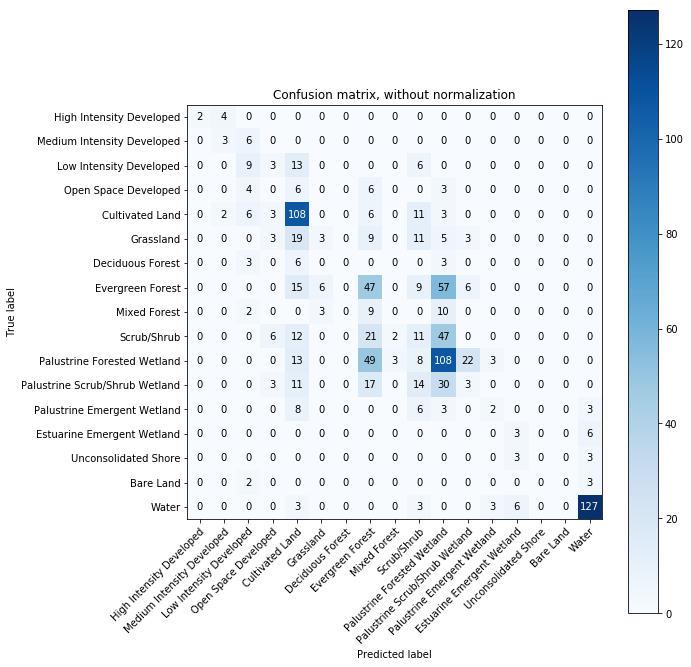

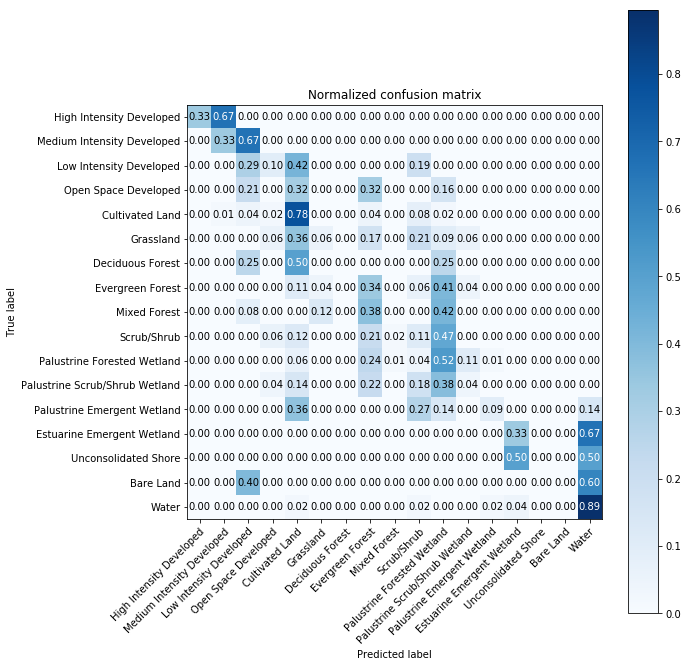

In [98]:
pred_index = rf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

(array([  2.,   9.,  32.,  18., 214.,   0.,  12.,   0., 164.,   5.,  79.,
        269.,  34.,   8.,   0.,   0.,  12.,   0.,   0., 142.]),
 array([ 2.  ,  2.95,  3.9 ,  4.85,  5.8 ,  6.75,  7.7 ,  8.65,  9.6 ,
        10.55, 11.5 , 12.45, 13.4 , 14.35, 15.3 , 16.25, 17.2 , 18.15,
        19.1 , 20.05, 21.  ]),
 <a list of 20 Patch objects>)

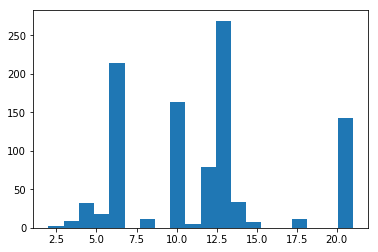

In [99]:
plt.hist(pred_index, bins=20)

#### Creating training data that contains a 3x3 tile

In [109]:
batch_size = 50000
sk_im_batch, sk_label_batch = sk_tile_generator([landsat_dataset], label_dataset, 3, 3, train_px, batch_size)
print(sk_im_batch.shape, sk_label_batch.shape)

wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
(50000, 63) (50000, 23)


In [108]:
batch_size = 1000
sk_im_batch_val, sk_label_batch_val = sk_tile_generator([landsat_dataset], label_dataset, 3, 3, val_px, batch_size)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(1000, 63) (1000, 23)


In [110]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [111]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 100.0%


In [112]:
label_index = np.argmax(sk_label_batch_val, axis=1)

rf.score(sk_im_batch_val, label_index)

0.488

In [113]:
bands = [1, 2, 3, 4, 5, 6, 7]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.022661240266950693
Band 2 importance: 0.015913569474774642
Band 3 importance: 0.015443475641588156
Band 4 importance: 0.011884559956153513
Band 5 importance: 0.011781815585605575
Band 6 importance: 0.012572999001945315
Band 7 importance: 0.013389758830972695


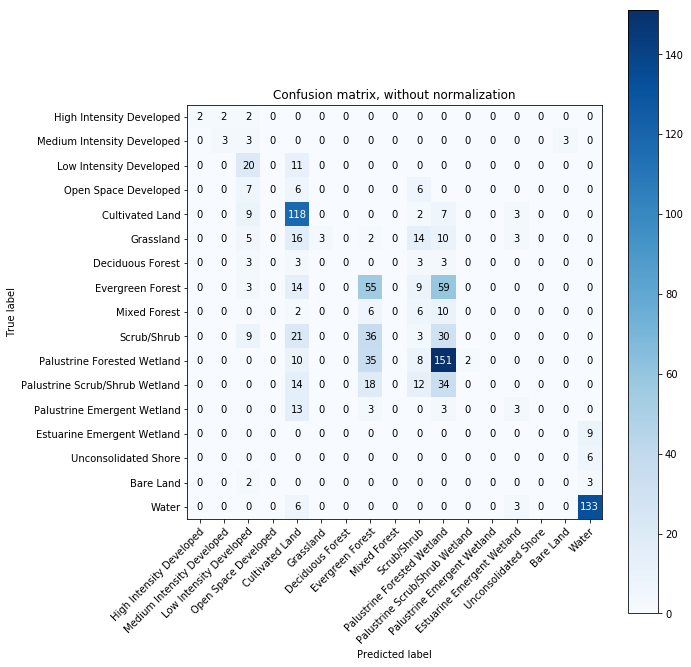

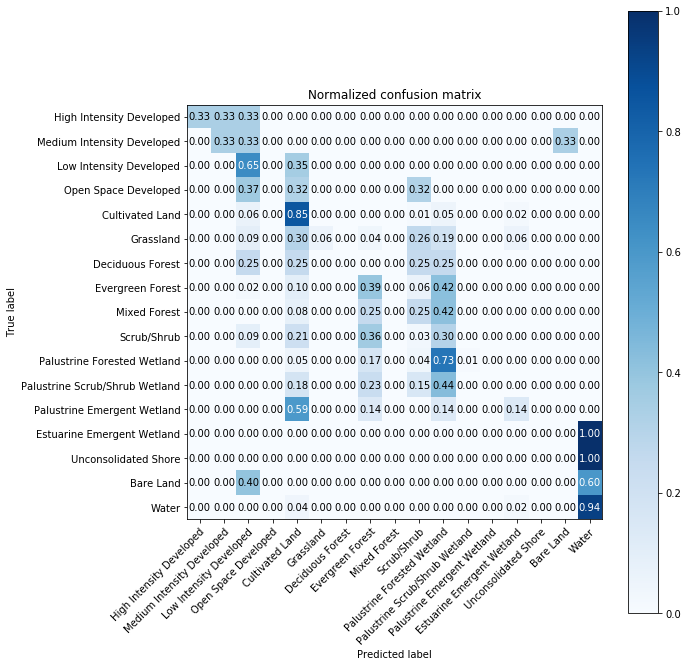

In [114]:
pred_index = rf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

### SVM

In [115]:
from sklearn import svm
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [116]:
svm_clf.score(sk_im_batch_val, np.argmax(sk_label_batch_val, axis=1))

0.441

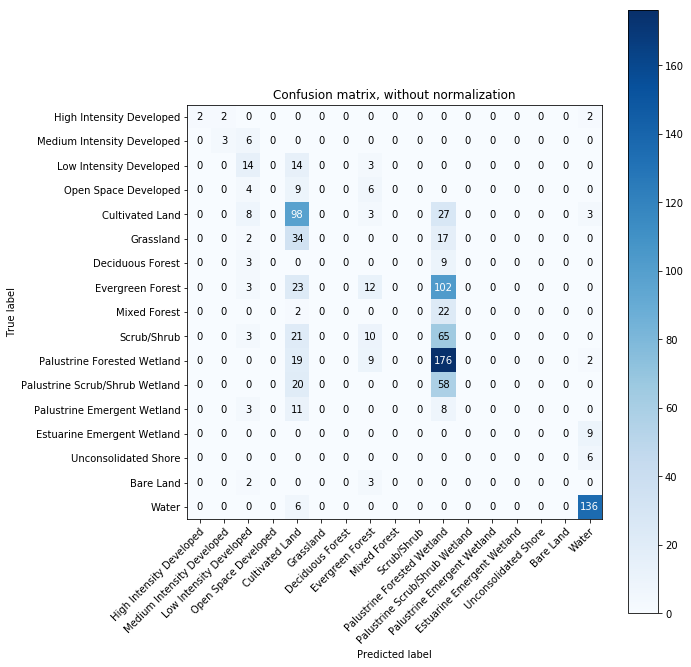

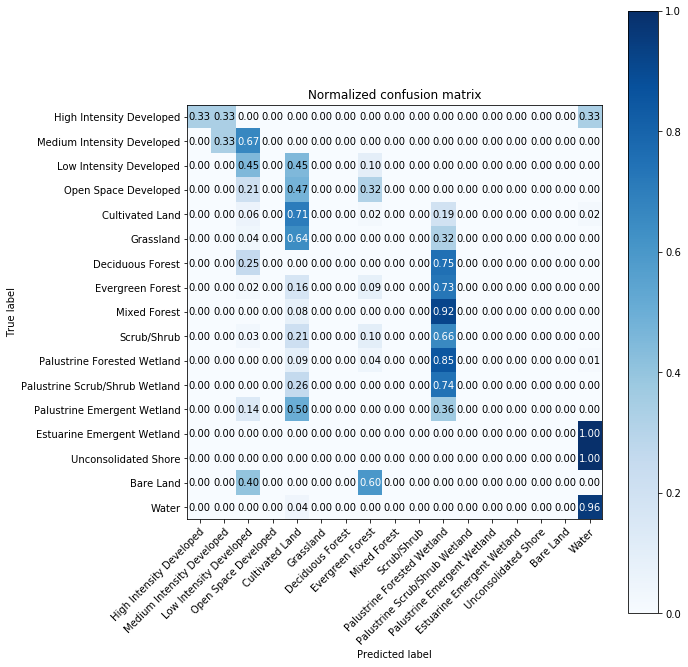

In [117]:
pred_index = svm_clf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [ ]:
# get a balanced percent of each class
# look at the classes that are consistently mis classified
# think about adding NDVI or taking out bands


In [19]:
min(n_samples, n_features)

8

In [24]:
sk_im_batch, sk_label_batch = sk_tile_generator(landsat_datasets, label_dataset, 3, 3, train_px, batch_size)

wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape
wrong shape


In [25]:
print(sk_im_batch.shape, sk_label_batch.shape)

(50000, 72) (50000, 23)


n_digits: 19, 	 n_samples 50000, 	 n_features 72
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


k-means++	14.34s	13360	0.127	0.122	0.125	0.045	0.121	0.100


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


random   	14.61s	13500	0.126	0.118	0.122	0.045	0.117	0.103


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


PCA-based	1.69s	14729	0.115	0.145	0.128	0.044	0.114	0.236
__________________________________________________________________________________


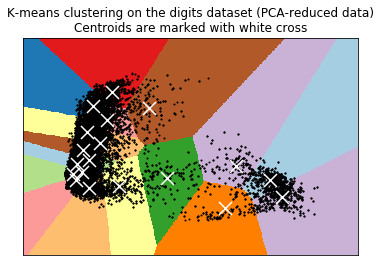

In [56]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = sk_im_batch

n_samples, n_features = sk_im_batch.shape
n_digits = len(np.unique(np.argmax(sk_label_batch, axis=1)))
labels = np.argmax(sk_label_batch, axis=1)

sample_size = 5000

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [57]:
centroids.shape

(19, 2)

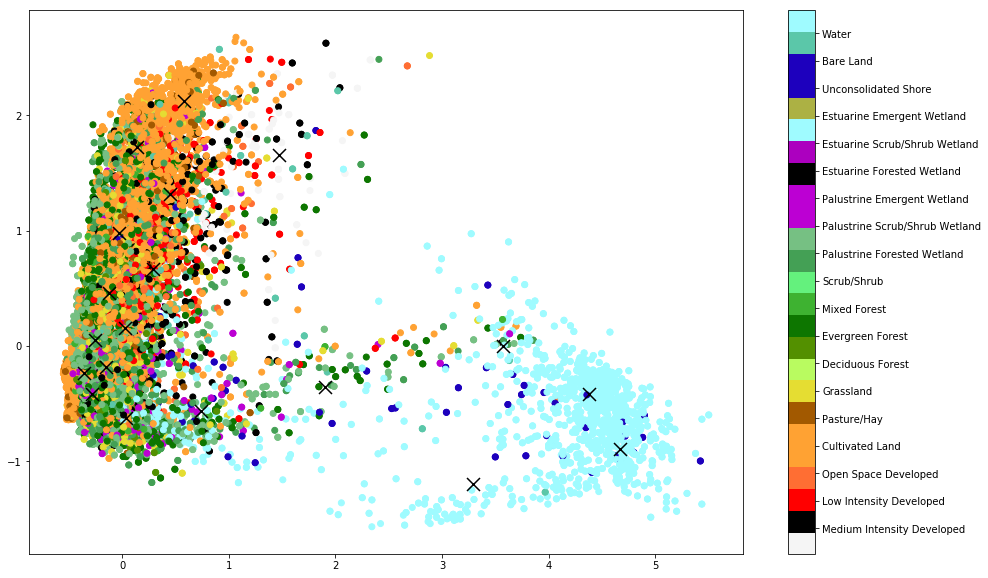

In [59]:
fig = plt.figure(figsize=(16,10))
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=6,
            color='black', zorder=10)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=np.argmax(sk_label_batch, axis=1), cmap=cmap)
cb = plt.colorbar()
loc = np.arange(0,max(class_names),max(class_names)/float(len(class_names)))
cb.set_ticks(loc)
cb.set_ticklabels(class_names)

In [28]:
reduced_data.shape

(50000, 2)

In [30]:
np.argmax(sk_label_batch, axis=1).shape

(50000,)

In [32]:
# next setup a colormap for our map
colors = dict((
(0, (245,245,245, 255)), # Background
(1, (0,0,0)), # Unclassified (Cloud, Shadow, etc)
(2, (255,0,0)), # High Intensity Developed
(3, (255, 110, 51)), # Medium Intensity Developed
(4, (255, 162, 51)), # Low Intensity Developed
(5, (255, 162, 51)), # Open Space Developed
(6, (162, 89, 0)), # Cultivated Land
(7, (229, 221, 50)), # Pasture/Hay
(8, (185, 251, 96)), # Grassland
(9, (83, 144, 0)), # Deciduous Forest
(10, (13, 118, 0  )), # Evergreen Forest
(11, (62, 178, 49)), # Mixed Forest
(12, (100, 241, 125)), # Scrub/Shrub
(13, (68, 160, 85)), # Palustrine Forested Wetland
(14, (118, 192, 131)), # Palustrine Scrub/Shrub Wetland
(15, (188, 0, 211)), # Palustrine Emergent Wetland
(16, (188, 0, 211)), # Estuarine Forested Wetland
(17, (0, 0, 0)), # Estuarine Scrub/Shrub Wetland
(18, (172, 0, 191)), # Estuarine Emergent Wetland
(19, (159, 251, 255)), # Unconsolidated Shore 
(20, (172, 177, 68)), # Bare Land
(21, (29, 0, 189)), # Water
(22, (29, 0, 189)), # Palustrine Aquatic Bed
(23, (91, 199, 169)), # Estuarine Aquatic Bed
(24, (159, 251, 255)), # Tundra
(25, (159, 251, 255)), # Snow/Ice
))

n = 25

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

In [62]:
sk_im_batch.shape

(50000, 8)

In [63]:
np.argmax(sk_label_batch, axis=1).shape

(50000,)

In [88]:
np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).shape

(1, 50000)

In [ ]:
np.concatenate((a, b.T), axis=1)

In [75]:
((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3])).shape

(50000,)

In [ ]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

In [108]:
y = np.argmax(sk_label_batch, axis=1)

# medium intensity and high intensity
y[y == 3] = 2

y[y == 9] = 11
y[y == 10] = 11
y[y == 13] = 11
y[y == 14] = 11 
y[y == 16] = 11

#y[y == 15] = 18

y[y == 22] = 23



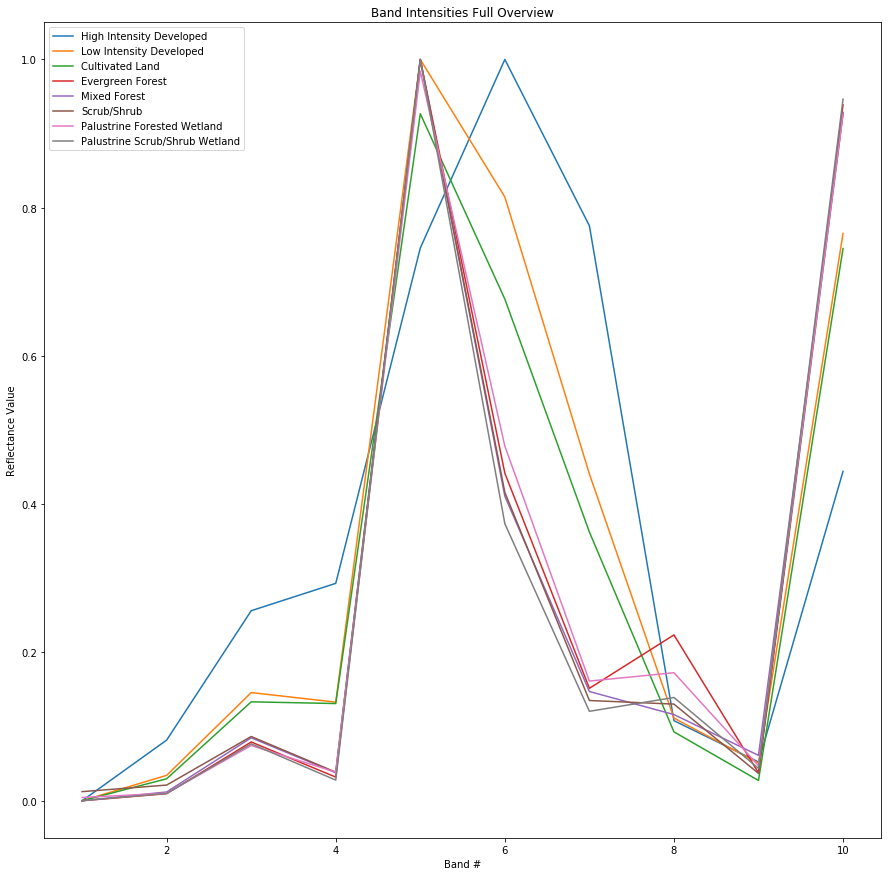

In [182]:
fig, ax = plt.subplots(1,1, figsize=[15,15])

# numbers 1-8
band_count = np.arange(1,11)

y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


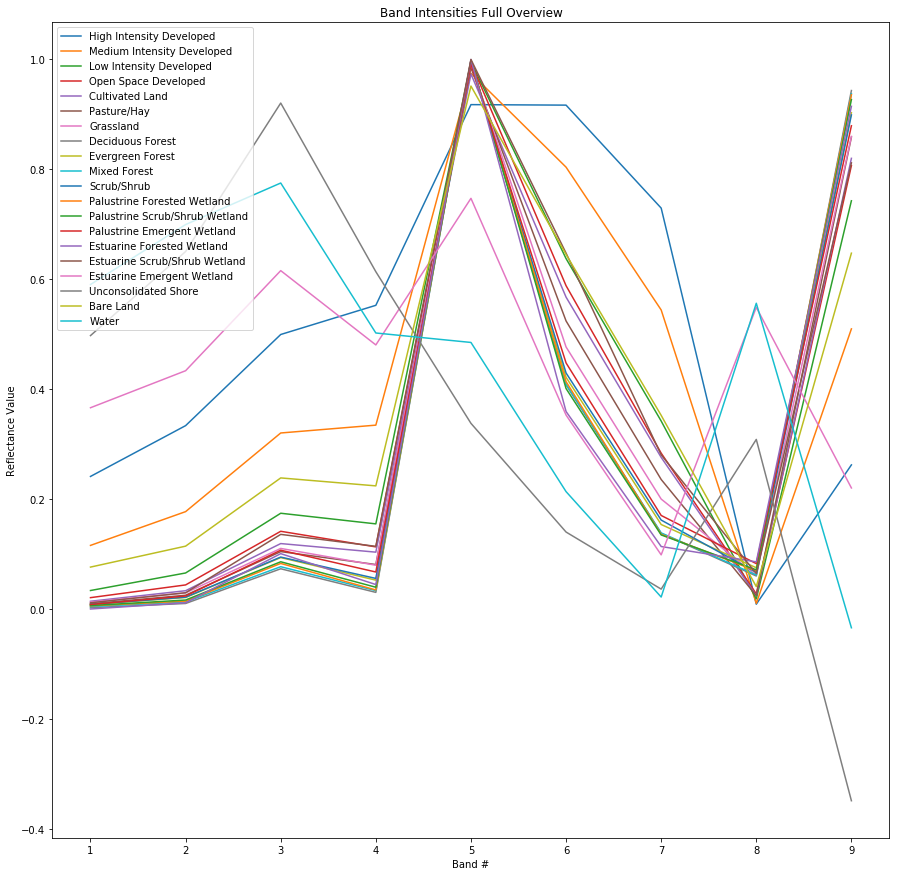

In [132]:
fig, ax = plt.subplots(1,1, figsize=[15,15])

# numbers 1-8
band_count = np.arange(1,10)

y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


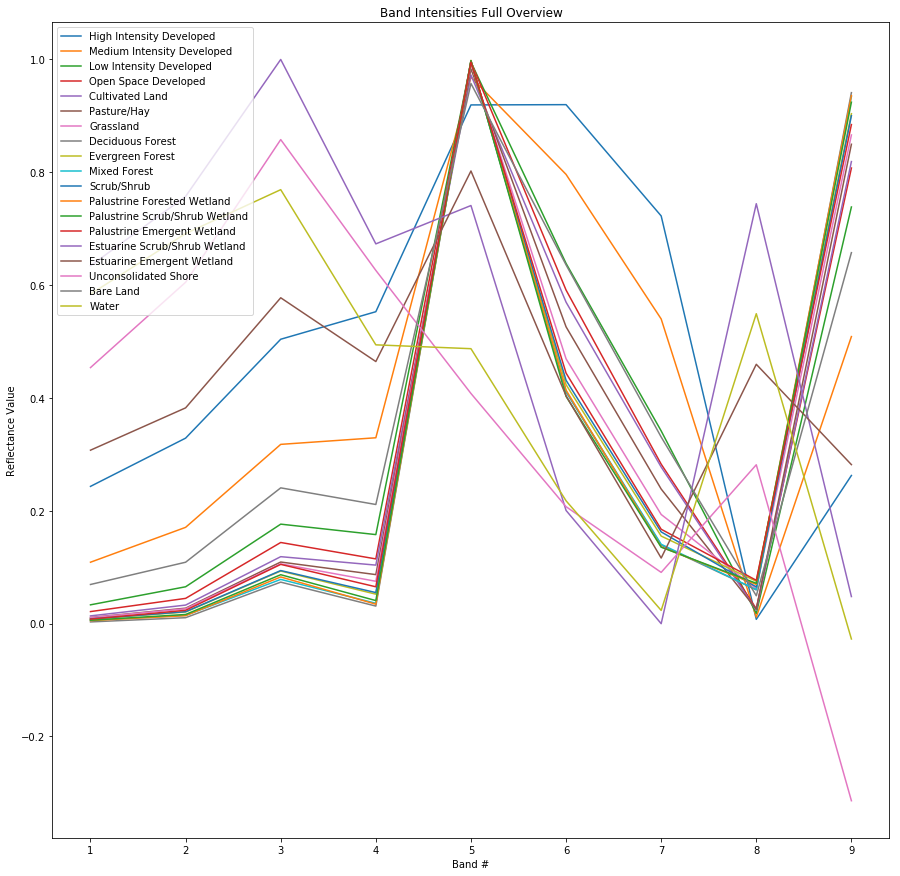

In [96]:
fig, ax = plt.subplots(1,1, figsize=[15,15])

# numbers 1-8
band_count = np.arange(1,10)

y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


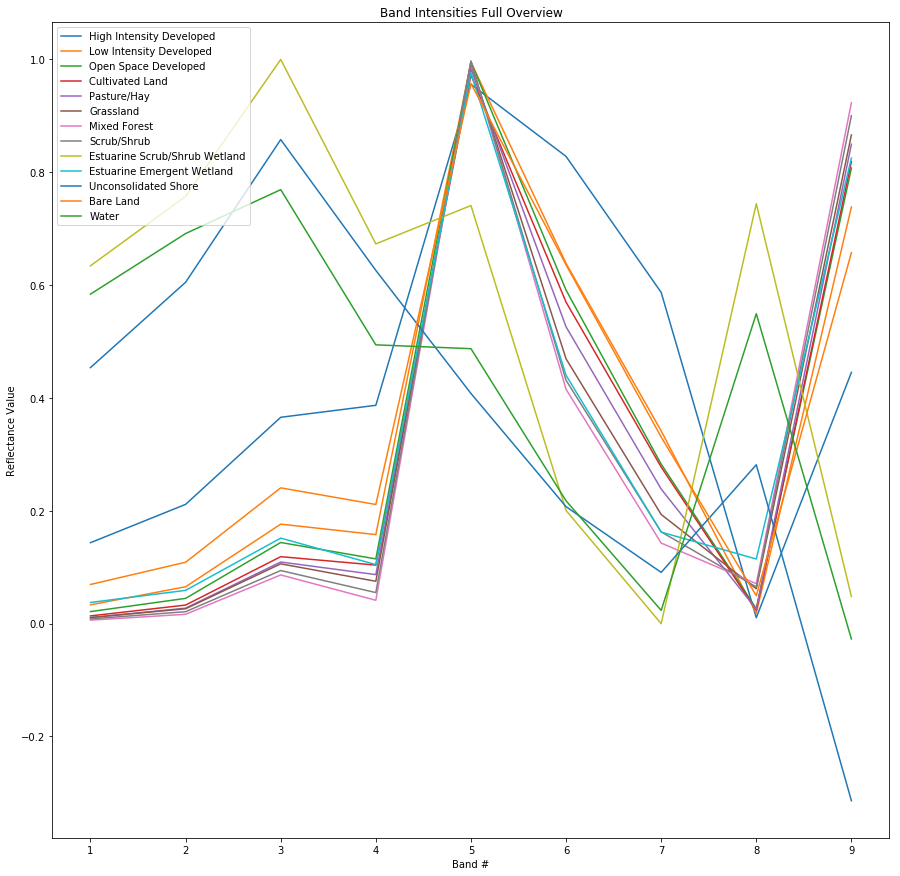

In [107]:
fig, ax = plt.subplots(1,1, figsize=[15,15])

# numbers 1-8
band_count = np.arange(1,10)

#y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


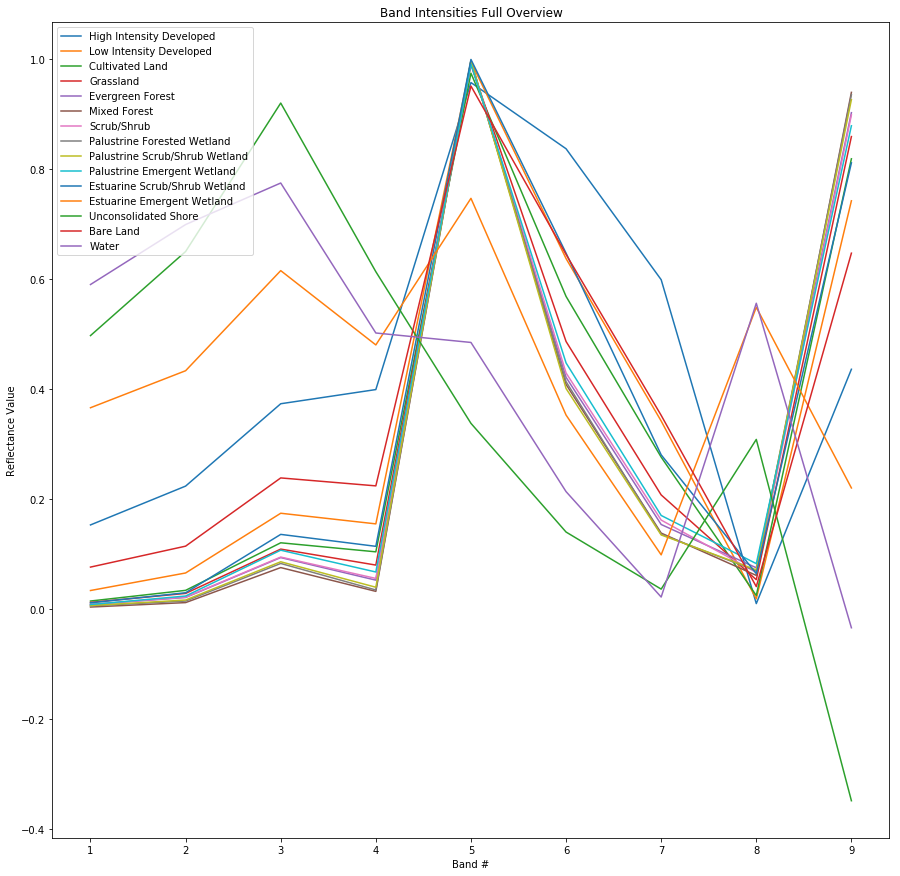

In [169]:
fig, ax = plt.subplots(1,1, figsize=[15,15])

# numbers 1-8
band_count = np.arange(1,10)

#y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


In [127]:
np.argmax(sk_label_batch, axis=1)

array([ 8, 13,  6, ..., 12, 15, 12])

In [133]:
unique, counts = np.unique(np.argmax(sk_label_batch, axis=1), return_counts=True)
dict(zip(unique, counts))

{2: 1156,
 3: 2738,
 4: 12083,
 5: 8352,
 6: 123734,
 7: 5936,
 8: 22182,
 9: 8203,
 10: 75956,
 11: 11170,
 12: 65378,
 13: 96729,
 14: 31948,
 15: 10235,
 16: 2,
 17: 44,
 18: 1340,
 19: 250,
 20: 2091,
 21: 20473}

In [170]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{2: 3894,
 4: 12083,
 6: 132086,
 8: 28118,
 10: 75956,
 11: 19373,
 12: 65378,
 13: 96731,
 14: 31948,
 15: 10235,
 17: 44,
 18: 1340,
 19: 250,
 20: 2091,
 21: 20473}

In [134]:
from sklearn.metrics.pairwise import cosine_similarity

spectral_sigs = []

y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)
classes = np.unique(y)

for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    spectral_sigs.append(band_intensity)
    ax.plot(band_count, band_intensity, label=class_names[class_type])



In [143]:
classes

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21])

In [138]:
cosine_similarity(spectral_sigs, spectral_sigs).shape

(20, 20)

In [140]:
cos_sim = cosine_similarity(spectral_sigs, spectral_sigs)

In [164]:
cos_sim_top = np.argsort(-cos_sim)[:,:5]
cos_sim_top_score = np.sort(-cos_sim)[:,:5]

In [167]:
for i, top in enumerate(cos_sim_top):
    print('For ', class_names[classes[i]], 'with', dict(zip(unique, counts))[classes[i]], 'the most similar are:')
    for index, class_index in enumerate(top):
        class_id = classes[class_index]
        score = round(cos_sim_top_score[i][index], 3)
        print('\t', class_names[class_id], '-', class_id, '-', score)
    print('---')

For  High Intensity Developed with 1156 the most similar are:
	 High Intensity Developed - 2 - -1.0
	 Medium Intensity Developed - 3 - -0.963
	 Bare Land - 20 - -0.895
	 Low Intensity Developed - 4 - -0.848
	 Estuarine Scrub/Shrub Wetland - 17 - -0.807
---
For  Medium Intensity Developed with 2738 the most similar are:
	 Medium Intensity Developed - 3 - -1.0
	 Bare Land - 20 - -0.98
	 High Intensity Developed - 2 - -0.963
	 Low Intensity Developed - 4 - -0.959
	 Estuarine Scrub/Shrub Wetland - 17 - -0.935
---
For  Low Intensity Developed with 12083 the most similar are:
	 Low Intensity Developed - 4 - -1.0
	 Open Space Developed - 5 - -0.997
	 Estuarine Scrub/Shrub Wetland - 17 - -0.996
	 Cultivated Land - 6 - -0.995
	 Bare Land - 20 - -0.995
---
For  Open Space Developed with 8352 the most similar are:
	 Open Space Developed - 5 - -1.0
	 Cultivated Land - 6 - -1.0
	 Estuarine Scrub/Shrub Wetland - 17 - -0.999
	 Pasture/Hay - 7 - -0.997
	 Low Intensity Developed - 4 - -0.997
---
For  C

In [168]:
# medium intensity and high intensity
y[y == 3] = 2

# open space developed and cultivated land
y[y == 5] = 6

# pasture/hay and grassland
y[y == 7] = 8

# deciduous forest and mixed forest
y[y == 9] = 11

# estuarine forest wetland to palustrine forested wetland
y[y == 16] = 13

In [112]:
class_names

{0: 'Background',
 1: 'Unclassified',
 2: 'High Intensity Developed',
 3: 'Medium Intensity Developed',
 4: 'Low Intensity Developed',
 5: 'Open Space Developed',
 6: 'Cultivated Land',
 7: 'Pasture/Hay',
 8: 'Grassland',
 9: 'Deciduous Forest',
 10: 'Evergreen Forest',
 11: 'Mixed Forest',
 12: 'Scrub/Shrub',
 13: 'Palustrine Forested Wetland',
 14: 'Palustrine Scrub/Shrub Wetland',
 15: 'Palustrine Emergent Wetland',
 16: 'Estuarine Forested Wetland',
 17: 'Estuarine Scrub/Shrub Wetland',
 18: 'Estuarine Emergent Wetland',
 19: 'Unconsolidated Shore',
 20: 'Bare Land',
 21: 'Water',
 22: 'Palustrine Aquatic Bed',
 23: 'Estuarine Aquatic Bed',
 24: 'Tundra',
 25: 'Snow/Ice'}